In [3]:
from galvani import BioLogic
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

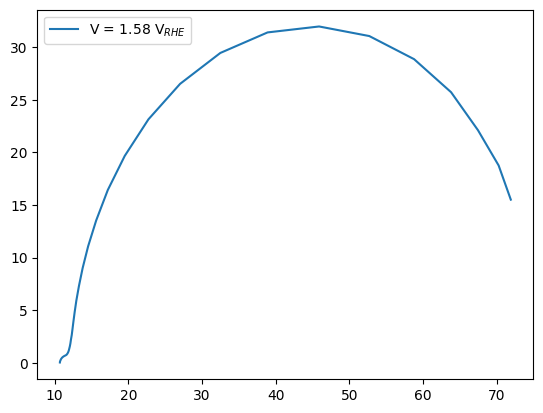

In [7]:
mpr_file = BioLogic.MPRfile('MPR files/1_58V_10cyc.mpr')
df = pd.DataFrame(mpr_file.data)

freq_min = 4
freq_max = 1e6
filtered_df = df[(df['freq/Hz'] >= freq_min) & (df['freq/Hz'] <= freq_max)]

Ewe = filtered_df["<Ewe>/V"].mean()

frequencies = filtered_df['freq/Hz'].values
real = filtered_df['Re(Z)/Ohm'].values
imaginary = -filtered_df['-Im(Z)/Ohm'].values

Z = np.concatenate((real, imaginary))

omega = 2 * np.pi * frequencies

plt.plot(real, -imaginary, label = f"V = {Ewe:.2f} V$_{{RHE}}$")
plt.legend()

In [8]:
# Define the R-RC-RC equivalent circuit model
def rrcrc_model(omega, R0, R1, C1, R2, C2):
    Z_R1C1 = R1 / (1 + 1j * omega * R1 * C1)
    Z_R2C2 = R2 / (1 + 1j * omega * R2 * C2)
    Z = R0 + Z_R1C1 + Z_R2C2
    return np.concatenate((np.real(Z), np.imag(Z)))

Optimal parameters: R0=10.934139856818208, R1=1.5357401148687668, C1=3.19517151839017e-05, R2=63.870719652984796, C2=0.00011908969502598487
R^2 (Real part): 0.999552768887952
R^2 (Imaginary part): 0.998428858933039


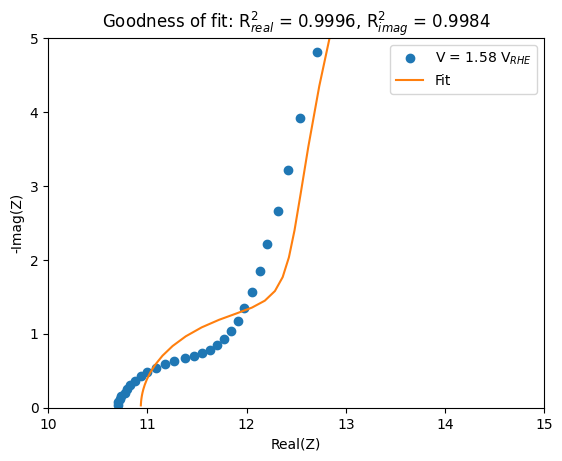

In [9]:
Rs_guess = 11.

R_guess = 1.5
n_guess = 1.
Q_guess = 3.2e-5

R2_guess = 6e4
n2_guess = 1.
Q2_guess = 1.2e-4

initial_guess = [Rs_guess, R_guess, Q_guess, R2_guess, Q2_guess]
bounds = (
    [5, 1, 1e-7, 1, 1e-7],  # Lower bounds
    [15, 5, 1e-3, 1e6, 1e-3]  # Upper bounds
)

popt, pcov = curve_fit(rrcrc_model, omega, Z, p0=initial_guess, bounds=bounds)

R0_opt, R1_opt, C1_opt, R2_opt, C2_opt = popt
print(f'Optimal parameters: R0={R0_opt}, R1={R1_opt}, C1={C1_opt}, R2={R2_opt}, C2={C2_opt}')

Z_fit = rrcrc_model(omega, *popt)
real_fit = Z_fit[:len(frequencies)]
imaginary_fit = Z_fit[len(frequencies):]

def calculate_r_squared(observed, predicted):
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    return 1 - (ss_res / ss_tot)

r_squared_real = calculate_r_squared(real, real_fit)
r_squared_imaginary = calculate_r_squared(imaginary, imaginary_fit)
print(f'R^2 (Real part): {r_squared_real}')
print(f'R^2 (Imaginary part): {r_squared_imaginary}')

plt.plot(real, -imaginary, 'o', label=f"V = {Ewe:.2f} V$_{{RHE}}$")
plt.plot(real_fit, -imaginary_fit, '-', label='Fit')
plt.xlabel('Real(Z)')
plt.ylabel('-Imag(Z)')
plt.xlim([10,15])
plt.ylim([0,5])
plt.title(f'Goodness of fit: R$^2_{{real}}$ = {r_squared_real:.4f}, R$^2_{{imag}}$ = {r_squared_imaginary:.4f}')
plt.legend()


#### Raw functions

In [ ]:
def cir_RsRQRQ(w, Rs, R='none', Q='none', n=1., R2='none', Q2='none', n2=1.):
    '''
    Simulation Function: -Rs-RQ-RQ-    
    
    Inputs
    ----------
    w = Angular frequency [1/s]
    Rs = Series Resistance [Ohm]
    
    R = Resistance [Ohm]
    Q = Constant phase element [s^n/ohm]
    n = Constant phase element exponent [-]

    R2 = Resistance [Ohm]
    Q2 = Constant phase element [s^n/ohm]
    n2 = Constant phase element exponent [-]
    '''     
    return Rs + (R/(1+R*Q*(w*1j)**n)) + (R2/(1+R2*Q2*(w*1j)**n2))

In [ ]:
Rs_guess = 11.

R_guess = 1.5
n_guess = 1.
Q_guess = 3.2e-5

R2_guess = 64
n2_guess = 1.
Q2_guess = 1.2e-4

cir_RsRQRQ(1e-3, Rs_guess, R_guess, Q_guess, R2_guess, Q2_guess)

TypeError: can't multiply sequence by non-int of type 'float'

In [4]:
def cir_RsRQRQ(w, Rs, R='none', Q='none', n='none', fs='none', R2='none', Q2='none', n2='none', fs2='none'):
    '''
    Simulation Function: -Rs-RQ-RQ-    
    
    Inputs
    ----------
    w = Angular frequency [1/s]
    Rs = Series Resistance [Ohm]
    
    R = Resistance [Ohm]
    Q = Constant phase element [s^n/ohm]
    n = Constant phase element exponent [-]
    fs = Summit frequency of RQ circuit [Hz]

    R2 = Resistance [Ohm]
    Q2 = Constant phase element [s^n/ohm]
    n2 = Constant phase element exponent [-]
    fs2 = Summit frequency of RQ circuit [Hz]
    '''
    if R == 'none':
        R = (1/(Q*(2*np.pi*fs)**n))
    elif Q == 'none':
        Q = (1/(R*(2*np.pi*fs)**n))
    elif n == 'none':
        n = np.log(Q*R)/np.log(1/(2*np.pi*fs))

    if R2 == 'none':
        R2 = (1/(Q2*(2*np.pi*fs2)**n2))
    elif Q2 == 'none':
        Q2 = (1/(R2*(2*np.pi*fs2)**n2))
    elif n2 == 'none':
        n2 = np.log(Q2*R2)/np.log(1/(2*np.pi*fs2))
        
    return Rs + (R/(1+R*Q*(w*1j)**n)) + (R2/(1+R2*Q2*(w*1j)**n2))

,freq/Hz,Re(Z)/Ohm,-Im(Z)/Ohm,|Z|/Ohm,Phase(Z)/deg,time/s,<Ewe>/V,<I>/mA,Cs/µF,Cp/µF,cycle number,I Range,|Ewe|/V,|I|/A,Ns,(Q-Qo)/mA.h
0,1.000062,38.400322,806.245667,807.159607,-87.273148,312.020286,1.000616,0.000243,197.390366,196.943619,1.0,41,0.010063,0.000012,0,-2.179642e-07
1,1.259677,30.884302,646.315186,647.052673,-87.264191,313.724934,1.000596,0.000218,195.486389,195.041031,1.0,41,0.010060,0.000016,0,8.967263e-08
2,1.584686,27.022837,517.513733,518.218750,-87.010918,315.090120,1.000609,0.000205,194.068436,193.540756,1.0,41,0.010064,0.000019,0,6.525926e-07
3,1.995020,23.439560,413.990509,414.653534,-86.759453,316.183168,1.000609,0.000182,192.700378,192.084625,1.0,41,0.010068,0.000024,0,1.013493e-06
4,2.511248,20.886562,330.393616,331.053162,-86.382736,317.509056,1.000614,0.000211,191.822205,191.058640,1.0,40,0.010060,0.000030,0,5.843827e-07
5,3.162958,19.302885,264.014099,264.718811,-85.818367,318.214032,1.000622,0.000118,190.589798,189.576401,1.0,40,0.010064,0.000038,0,3.992324e-07
6,3.981903,18.087473,210.314438,211.090790,-85.084541,318.784960,1.000619,0.000141,190.046692,188.651352,1.0,40,0.010063,0.000048,0,1.111104e-06
7,5.014442,16.901197,167.889526,168.738098,-84.251480,319.248192,1.000602,0.000079,189.048782,187.152145,1.0,40,0.010064,0.000060,0,1.091254e-06
8,6.310582,16.334602,134.005783,134.997665,-83.050232,319.627221,1.000605,0.000047,188.203262,185.447815,1.0,40,0.010068,0.000075,0,4.577759e-07
9,7.947609,15.522514,106.870865,107.992271,-81.735832,320.201470,1.000610,0.000103,187.380478,183.509109,1.0,40,0.010068,0.000093,0,1.276585e-06
